In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your dataset
df = pd.read_csv('/content/train_citrus_update - lstm.csv')  # symptom, caption
df['gejala'] = df['gejala'].str.lower()
df['caption'] = df['caption'].str.lower().apply(lambda x: 'startseq ' + x + ' endseq')

# Tokenizers
symptom_tokenizer = Tokenizer()
caption_tokenizer = Tokenizer()

symptom_tokenizer.fit_on_texts(df['gejala'])
caption_tokenizer.fit_on_texts(df['caption'])

X_symptom = symptom_tokenizer.texts_to_sequences(df['gejala'])
X_symptom = pad_sequences(X_symptom, padding='post')
max_symptom_len = X_symptom.shape[1]

y_caption = caption_tokenizer.texts_to_sequences(df['caption'])
max_caption_len = max(len(seq) for seq in y_caption)
y_caption = pad_sequences(y_caption, maxlen=max_caption_len, padding='post')

vocab_symptom = len(symptom_tokenizer.word_index) + 1
vocab_caption = len(caption_tokenizer.word_index) + 1

# Prepare decoder input and target
decoder_input_data = y_caption[:, :-1]  # everything except last token
decoder_target_data = y_caption[:, 1:]  # everything except first token
decoder_target_data = tf.keras.utils.to_categorical(decoder_target_data, vocab_caption)

# Encoder
encoder_inputs = Input(shape=(max_symptom_len,))
enc_emb = Embedding(vocab_symptom, 128)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_caption_len - 1,))
dec_emb_layer = Embedding(vocab_caption, 128)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_caption, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 128)    │      1,024 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 25, 128)   │      6,016 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 25, 256), │    394,240 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 47)    │     12,079 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 807,599 (3.08 MB)

 Trainable params: 807,599 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7767
Epoch 1: val_loss improved from inf to 0.90628, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.7495 - val_loss: 0.9063
Epoch 2/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8848
Epoch 2: val_loss improved from 0.90628 to 0.13053, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8494 - val_loss: 0.1305
Epoch 3/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1851
Epoch 3: val_loss improved from 0.13053 to 0.03018, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1810 - val_loss: 0.0302
Epoch 4/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0707
Epoch 4: val_loss improved from 0.03018 to 0.00975, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0686 - val_loss: 0.0097
Epoch 5/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0251
Epoch 5: val_loss improved from 0.00975 to 0.00594, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0253 - val_loss: 0.0059
Epoch 6/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0209
Epoch 6: val_loss improved from 0.00594 to 0.00355, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0206 - val_loss: 0.0035
Epoch 7/50
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115
Epoch 7: val_loss improved from 0.00355 to 0.00259, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - val_loss: 0.0026
Epoch 8/50
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110
Epoch 8: val_loss improved from 0.00259 to 0.00192, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0019
Epoch 9/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096
Epoch 9: val_loss improved from 0.00192 to 0.00151, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0015
Epoch 10/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059
Epoch 10: val_loss improved from 0.00151 to 0.00136, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 11/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 11: val_loss improved from 0.00136 to 0.00102, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - val_loss: 0.0010
Epoch 12/50
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039
Epoch 12: val_loss improved from 0.00102 to 0.00087, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - val_loss: 8.7099e-04
Epoch 13/50
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041
Epoch 13: val_loss improved from 0.00087 to 0.00070, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 7.0416e-04
Epoch 14/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 14: val_loss improved from 0.00070 to 0.00061, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 6.0896e-04
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 15: val_loss improved from 0.00061 to 0.00053, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 5.2716e-04
Epoch 16/50
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 16: val_loss improved from 0.00053 to 0.00047, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 4.7144e-04
Epoch 17/50
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 17: val_loss improved from 0.00047 to 0.00043, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 4.3208e-04
Epoch 18/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 18: val_loss improved from 0.00043 to 0.00037, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 3.6768e-04
Epoch 19/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 19: val_loss improved from 0.00037 to 0.00034, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 3.4016e-04
Epoch 20/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 20: val_loss improved from 0.00034 to 0.00031, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 3.1098e-04
Epoch 21/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 21: val_loss improved from 0.00031 to 0.00027, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 2.7155e-04
Epoch 22/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 22: val_loss improved from 0.00027 to 0.00025, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 2.5039e-04
Epoch 23/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 23: val_loss improved from 0.00025 to 0.00023, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 2.3262e-04
Epoch 24/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 24: val_loss improved from 0.00023 to 0.00023, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 2.3216e-04
Epoch 25/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 25: val_loss improved from 0.00023 to 0.00021, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 2.0712e-04
Epoch 26/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4789e-04
Epoch 26: val_loss improved from 0.00021 to 0.00018, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8070e-04 - val_loss: 1.7901e-04
Epoch 27/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010
Epoch 27: val_loss improved from 0.00018 to 0.00017, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 1.7148e-04
Epoch 28/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 28: val_loss did not improve from 0.00017
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 2.2947e-04
Epoch 29/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172
Epoch 29: val_loss did not improve from 0.00017
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0171 - val_loss: 3.0943e-04
Epoch 30/50
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036
Epoch 30: val_loss did not improve from 0.00017
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 1.9716e-04
Epoch 31/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 31: val_loss improved from 0.00017 to 0.00016, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 1.5743e-04
Epoch 32/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9878e-04
Epoch 32: val_loss improved from 0.00016 to 0.00014, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9820e-04 - val_loss: 1.3813e-04
Epoch 33/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3626e-04
Epoch 33: val_loss improved from 0.00014 to 0.00012, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3930e-04 - val_loss: 1.2072e-04
Epoch 34/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6739e-04
Epoch 34: val_loss improved from 0.00012 to 0.00011, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6600e-04 - val_loss: 1.1134e-04
Epoch 35/50
63/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2562e-04
Epoch 35: val_loss improved from 0.00011 to 0.00011, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3174e-04 - val_loss: 1.0606e-04
Epoch 36/50
63/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0456e-04
Epoch 36: val_loss improved from 0.00011 to 0.00009, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2550e-04 - val_loss: 9.2662e-05
Epoch 37/50
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6333e-04
Epoch 37: val_loss improved from 0.00009 to 0.00008, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6311e-04 - val_loss: 8.3851e-05
Epoch 38/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0572e-04
Epoch 38: val_loss improved from 0.00008 to 0.00008, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1990e-04 - val_loss: 8.0532e-05
Epoch 39/50
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9767e-04
Epoch 39: val_loss improved from 0.00008 to 0.00007, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0609e-04 - val_loss: 7.3805e-05
Epoch 40/50
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6101e-04
Epoch 40: val_loss improved from 0.00007 to 0.00007, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5983e-04 - val_loss: 6.8103e-05
Epoch 41/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1523e-04
Epoch 41: val_loss improved from 0.00007 to 0.00006, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2144e-04 - val_loss: 6.4417e-05
Epoch 42/50
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8393e-04
Epoch 42: val_loss improved from 0.00006 to 0.00006, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8942e-04 - val_loss: 6.2963e-05
Epoch 43/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5926e-04
Epoch 43: val_loss improved from 0.00006 to 0.00006, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6332e-04 - val_loss: 5.7003e-05
Epoch 44/50
63/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4458e-04
Epoch 44: val_loss improved from 0.00006 to 0.00005, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5162e-04 - val_loss: 5.4162e-05
Epoch 45/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3548e-04
Epoch 45: val_loss improved from 0.00005 to 0.00005, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3768e-04 - val_loss: 5.1758e-05
Epoch 46/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0260e-04
Epoch 46: val_loss improved from 0.00005 to 0.00005, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9216e-04 - val_loss: 4.9332e-05
Epoch 47/50
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4660e-04
Epoch 47: val_loss improved from 0.00005 to 0.00005, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5899e-04 - val_loss: 4.7739e-05
Epoch 48/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6240e-04
Epoch 48: val_loss improved from 0.00005 to 0.00005, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6154e-04 - val_loss: 4.5045e-05
Epoch 49/50
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6833e-04
Epoch 49: val_loss improved from 0.00005 to 0.00004, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5240e-04 - val_loss: 4.3848e-05
Epoch 50/50
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6025e-04
Epoch 50: val_loss improved from 0.00004 to 0.00004, saving model to caption_model_best.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6425e-04 - val_loss: 4.0463e-05


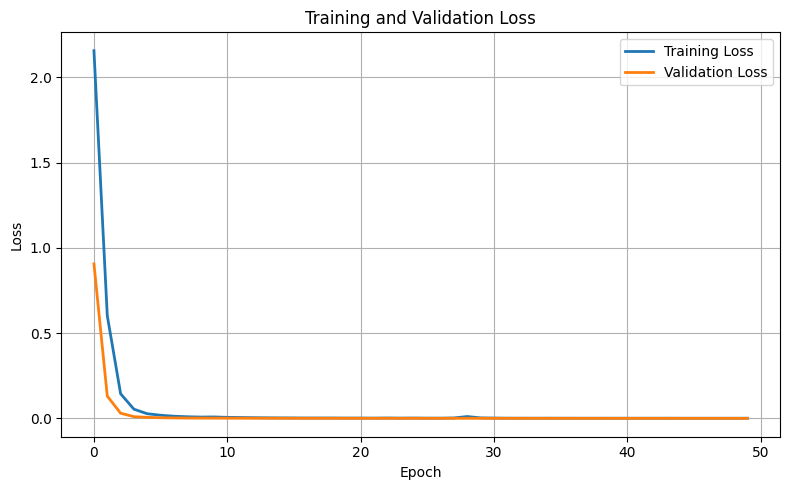

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# check
checkpoint = ModelCheckpoint(
    'caption_model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model and store history
history = model.fit(
    [X_symptom, decoder_input_data],
    decoder_target_data,
    batch_size=16,
    epochs=50,
    validation_split=0.1,
    callbacks=[checkpoint]
)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

# Rebuild encoder model for inference
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Rebuild decoder model for inference
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_hidden = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_hidden)
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_hidden,
    [decoder_outputs2, state_h2, state_c2]
)


# Use a random sample of 100 items (or set this lower if needed)
num_samples = 50
sample_indices = random.sample(range(len(df)), num_samples)

# Reverse word index for generating words from tokens
reverse_caption_index = {v: k for k, v in caption_tokenizer.word_index.items()}
start_token = caption_tokenizer.word_index['startseq']
end_token = caption_tokenizer.word_index['endseq']

smoothie = SmoothingFunction().method4
references = []
hypotheses = []

def generate_caption(symptom_seq):
    states_value = encoder_model.predict(symptom_seq, verbose=0)
    target_seq = np.array([[start_token]])
    decoded_sentence = []

    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_caption_index.get(sampled_token_index, '')

        if sampled_word == 'endseq' or len(decoded_sentence) > max_caption_len:
            break

        decoded_sentence.append(sampled_word)
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return ' '.join(decoded_sentence)

# Evaluate only on the sampled subset
for idx in sample_indices:
    input_seq = X_symptom[idx:idx+1]
    ref_caption = df['caption'].iloc[idx].replace('startseq ', '').replace(' endseq', '').split()
    generated_caption = generate_caption(input_seq).split()

    references.append([ref_caption])
    hypotheses.append(generated_caption)

# Calculate BLEU scores
bleu1 = np.mean([sentence_bleu(ref, hyp, weights=(1, 0, 0, 0), smoothing_function=smoothie) for ref, hyp in zip(references, hypotheses)])
bleu2 = np.mean([sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) for ref, hyp in zip(references, hypotheses)])
bleu3 = np.mean([sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) for ref, hyp in zip(references, hypotheses)])
bleu4 = np.mean([sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) for ref, hyp in zip(references, hypotheses)])
bleu_avg = (bleu1 + bleu2 + bleu3 + bleu4) / 4
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print(f"Average BLEU: {bleu_avg:.4f}")


BLEU-1: 0.9319
BLEU-2: 0.9294
BLEU-3: 0.9274
BLEU-4: 0.9236
Average BLEU: 0.9281


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ambil input dan hidden state dari encoder training
encoder_model = Model(encoder_inputs, [state_h, state_c])
encoder_model.save('encoder.h5')


In [ ]:
# Inference decoder input (satu langkah prediksi)
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)

# Reuse LSTM layer, masukkan state awal dari encoder
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# Reuse dense (softmax) layer
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Buat model inference decoder
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)
decoder_model.save('decoder.h5')


In [ ]:
import pickle

with open('symptom_tokenizer.pkl', 'wb') as f:
    pickle.dump(symptom_tokenizer, f)

with open('caption_tokenizer.pkl', 'wb') as f:
    pickle.dump(caption_tokenizer, f)
